(cartes-statistiques-chapitre)=
# Cartes statistiques

<table>
  <tr>
    <td align="center">
      <a href="https://github.com/elisabethloranger">
        <img src="https://avatars.githubusercontent.com/u/90270981?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Élisabeth Loranger</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
    </td>
    <td align="center">
      <a href="https://github.com/pbellec">
        <img src="https://avatars.githubusercontent.com/u/1670887?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Pierre bellec</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
    </td>
    <td align="center">
      <a href="https://github.com/eddyfortier">
        <img src="https://avatars.githubusercontent.com/u/72314243?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Eddy Fortier</b></sub>
      </a>
      <br />
        <a title="Révision du texte">👀</a>
    </td>
  </tr>
</table>

## Objectifs du cours

Dans ce chapitre, il sera question de l'utilisation du modèle de régression pour générer des cartes statistiques cérébrales de groupe. Les statistiques de groupe permettent de combiner les mesures du cerveau de plusieurs individus et ainsi de contraster des groupes (ex. groupe de personnes jeunes et groupe de personnes âgées) ou bien de tester l'association avec une variable continue (ex. l'âge).

Les objectifs spécifiques du cours portent sur les concepts suivants :
 * la régression linéaire,
 * le modèle linéaire général,
 * tests statistiques.

## Régression linéaire

### Variables

/home/pbellec/env/psy3018/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/pbellec/env/psy3018/lib/python3.8/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


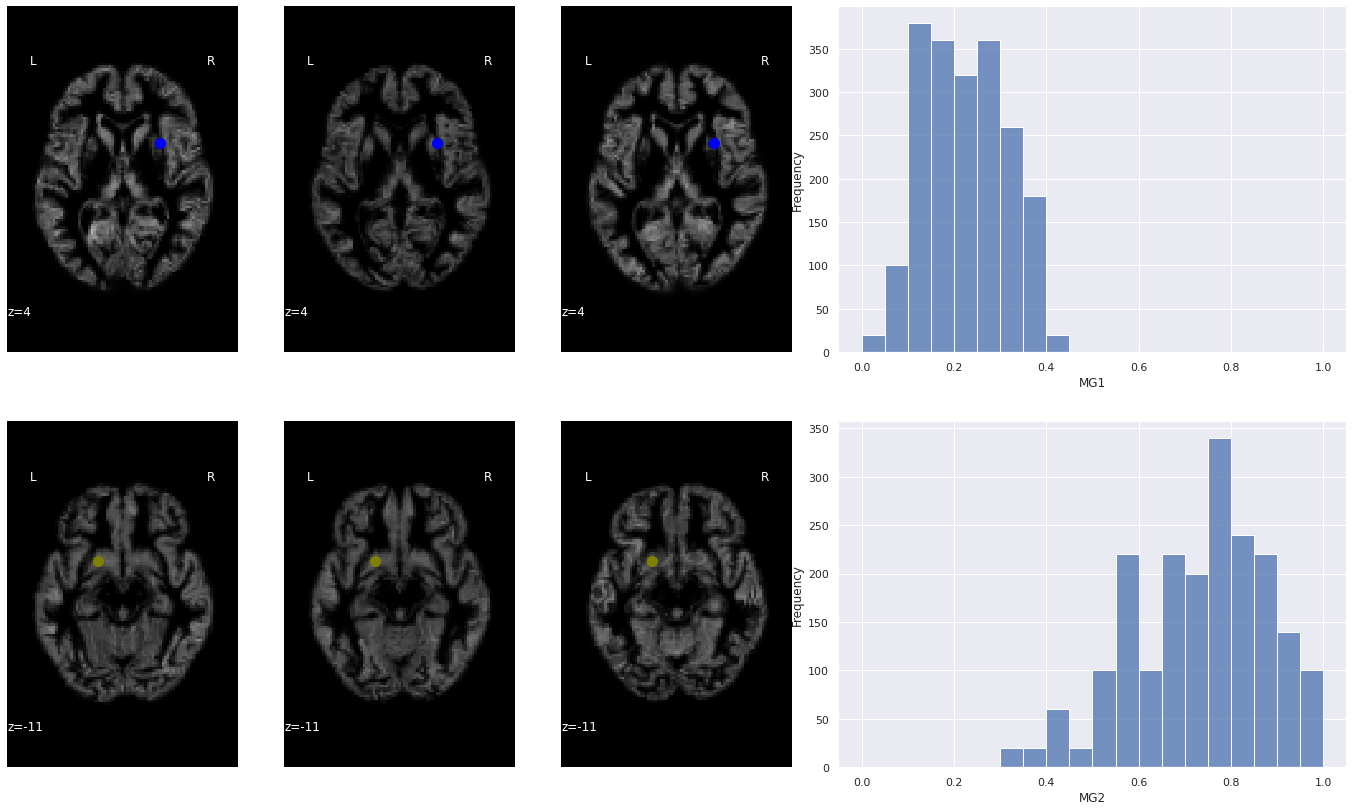

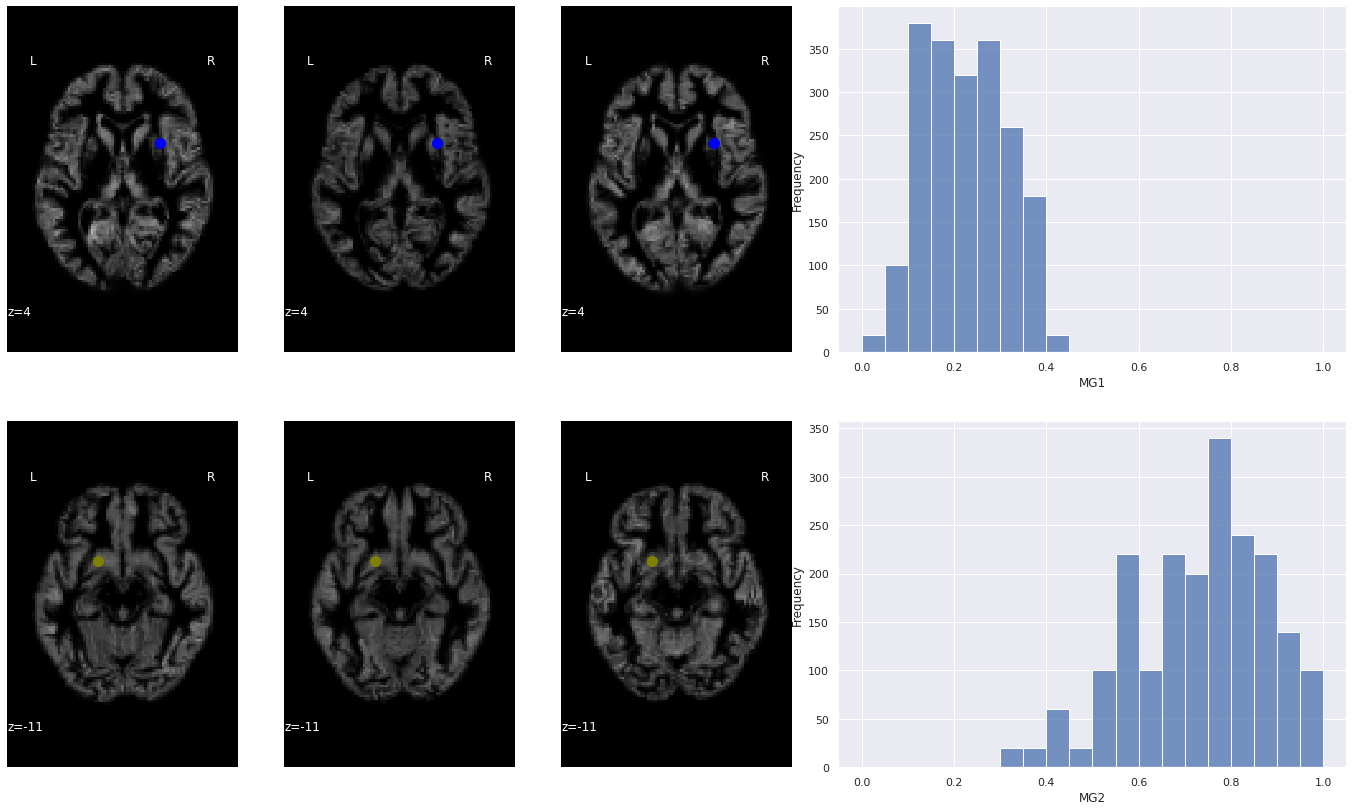

In [1]:
# Importer les librairies
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import get_data

# Charger les données
n_subjects = 100  
oasis_dataset = datasets.fetch_oasis_vbm(n_subjects=n_subjects)
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
age = oasis_dataset.ext_vars['age'].astype(float)
sex = oasis_dataset.ext_vars['mf'] == b'F'

# Conversion des données en pandas dataframe
# Deux voxels intéressants ont été sélectionnés
import pandas as pd
coords = np.array([[ 29.,  10.,   4.], [-19.,   8., -11.]])
colors = ['blue', 'olive']

from nilearn import input_data
masker = input_data.NiftiSpheresMasker(coords)
gm = masker.fit_transform(gray_matter_map_filenames)
subject_label = [f'sub-{num}' for num in range(n_subjects)]
df = pd.DataFrame({
    "subject_label": subject_label,
    "age": age,
    "sexe": oasis_dataset.ext_vars['mf'],
    "MG1": gm[:, 0],
    "MG2": gm[:, 1]
    })

df["sexe"] = df["sexe"].replace([b'F', b'M'], value=['femelle', 'male'])

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 14))

for i in range(0, 6):        
    nx = np.floor_divide(i, 3)
    ny = np.remainder(i, 3)
    ax = plt.subplot2grid((2, 5), (nx, ny), colspan=1)
    roi_img = plotting.plot_anat(
        gray_matter_map_filenames[i], cut_coords=[coords[nx][2]], figure=fig,
        axes=ax, display_mode='z', colorbar=False)
    roi_img.add_markers([coords[nx]], colors[nx], 100)

sns.set_theme(style="darkgrid")
ax = plt.subplot2grid((2, 5), (0, 3), colspan=2)
sns.histplot(
    df["MG1"], ax=ax, binwidth=0.05, binrange=[0, 1], stat='frequency')

ax = plt.subplot2grid((2, 5), (1, 3), colspan=2)
sns.histplot(
    df["MG2"], ax=ax, binwidth=0.05, binrange=[0, 1], stat='frequency')

from myst_nb import glue
glue("vbm-distribution-fig", fig, display=False)

```{glue:figure} vbm-distribution-fig
:figwidth: 800px
:name: vbm-distribution-fig
La position de deux voxels (illustrée à l'aide d'un cercle bleu (haut) et d'un cercle olive (bas)) est ici superposée sur des cartes de densité de matière grise pour différents sujets du jeu de données OASIS ([Marcus et al., 2010](https://dx.doi.org/10.1162%2Fjocn.2009.21407)). À droite, un histograme représente la distribution de la densité de matière grise pour le voxel correspondant, à travers un échantillon de 100 sujets. Cette figure est adaptée d'un tutoriel de la librairie [nilearn](https://nilearn.github.io/auto_examples/05_glm_second_level/plot_oasis.html#sphx-glr-auto-examples-05-glm-second-level-plot-oasis-py) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```
Les concepts présentés dans ce chapitre s’appliquent à la plupart des modalités d'imagerie vues dans le cours de façon plus ou moins identique. Afin de rendre les choses un peu plus concrètes, nous allons ici nous intéresser à une analyse morphométrique de type VBM (IRM structurelle). Cette analyse utilise le jeu de données OASIS ([Marcus et al., 2010](https://dx.doi.org/10.1162%2Fjocn.2009.21407)). Des cartes de densité de matière grise pour les données OASIS sont disponibles via la librairie [nilearn](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_oasis_vbm.html). Pour chaque voxel, on dispose d'une mesure locale de densité de matière grise qui varie entre 0 et 1. Comme toutes les images des 100 participants OASIS utilisés dans cet exemple ont été recalées dans un même espace stéréotaxique, chaque voxel est associé à une série de 100 mesures. Il s'agit de notre **variable dépendante**. On va par la suite chercher à expliquer les variations de cette mesure à travers les sujets à l'aide d'autres variables, appelées les **prédicteurs**. Pour notre exemple, nous allons démarrer avec l'âge des participants qui varie ici de 20 ans à 90 ans.

### Modèle linéaire

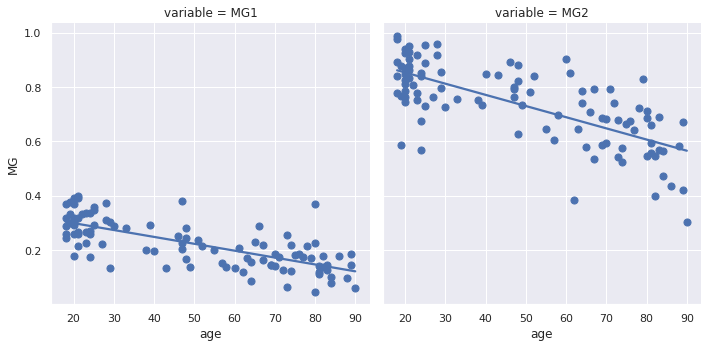

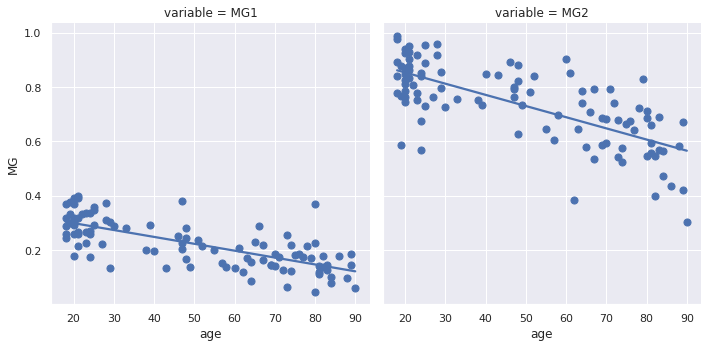

In [2]:
# On réorganise le DataFrame pour utiliser seaborn
df2 = df.melt(id_vars=["age", "sexe"], value_vars=["MG1", "MG2"], value_name="MG")
fig = sns.lmplot(x="age", y="MG", data=df2, col='variable',
           ci=None, scatter_kws={"s": 50, "alpha": 1})

# On colle la figure dans le jupyter book
from myst_nb import glue
glue("regression-vbm-fig", fig.fig, display=False)           

```{glue:figure} regression-vbm-fig
:figwidth: 800px
:name: regression-vbm-fig
Exemple de régression linéaire où la variable dépendante est la densité de matière grise pour un voxel et le prédicteur est l'âge. Les valeurs de densité de matière grise proviennent de 100 sujets de la base de données OASIS ([Marcus et al., 2010](https://dx.doi.org/10.1162%2Fjocn.2009.21407)). Les deux voxels utilisés ici sont les mêmes que ceux représentés dans la {numref}`vbm-distribution-fig` (voxel bleu à gauche, voxel olive à droite). La régression linéaire est réalisée à l'aide de la libraire [seaborn](https://seaborn.pydata.org) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```
Le concept soutenant le modèle de régression est une équation, ou une sorte de loi, qui va tenter de prédire la variable dépendante (ici, la densité de matière grise) à partir de prédicteurs (par exemple, l'âge). Mais contrairement à une loi physique qui tente de représenter une dépendance exacte (jusqu'à un certain degré), la présente loi ne capture qu'une fraction de la variance de notre mesure. La loi va donc incorporer un certain bruit représentant toutes les sources de variabilité que l'on ne peut pas capturer avec notre relation. La relation mathématique va prendre la forme suivante:

`densite_matiere_grise = b0 + b1 * age + e`

Où

 * `densite_matiere_grise` est la densité de matière grise mesurée pour un voxel
 * `age` est l'âge du participant de recherche
 * `b0` est une valeur constante, appelée en anglais "intercept" (l'ordonnée à l'origine). Cette valeur est identique pour tous les sujets. Dans ce cas-ci, elle représenterait la densité de matière grise observée à la naissance (`age=0`), en moyenne sur la population.
 * `b1` est une autre constante qui dans cet exemple mesure la réduction de matière grise par année de vie (en moyenne sur la population).
 * `e` est un bruit de mesure qui capture toutes les variations de `densite_matiere_grise` que l'on ne peut pas expliquer avec `age`. Typiquement, on suppose que la moyenne de `e` dans la population est `0` et que la variance de `e` est identique pour tous les sujets, égale à $\sigma^2$.

On ne connait évidemment pas les coefficients `b0` et `b1`. Il sera nécessaire d'utiliser une procédure statistique pour les `estimer`, c'est à dire deviner (au mieux) leurs valeurs à partir des données dont nous disposons. Par exemple, pour la région de couleur `olive` (graphe de droite dans {numref}`regression-vbm-fig`), on voit que l'on perd environ 25% de densité entre 20 ans et 90 ans (voir {numref}`regression-vbm-fig`). On perd donc environ 0.35% de densité de matière grise par an, soit `b1 ~ -0.0035`. En utilisant cette valeur et en remarquant que la densité de matière grise est d'à peu près `0.85` à `20` ans, on en déduit que la densité à la naissance devrait être `b0=0.92`. En pratique, la procédure statistique va choisir les valeurs `b0` et `b1` pour minimiser l'amplitude des résidus de la régression:

`residus = densite_matiere_grise - b0 - b1 * age`

Une fois les coefficients `b0` et `b1` estimés, on peut tracer une droite qui représente les valeurs de densité de matière grise prédites à partir de l'âge des sujets (voir {numref}`regression-vbm-fig`). Si le modèle permet d'expliquer une partie importante de la variabilité de la variable dépendante, les points mesurés seront proches de la droite de prédiction.

### Analyse massivement univariée

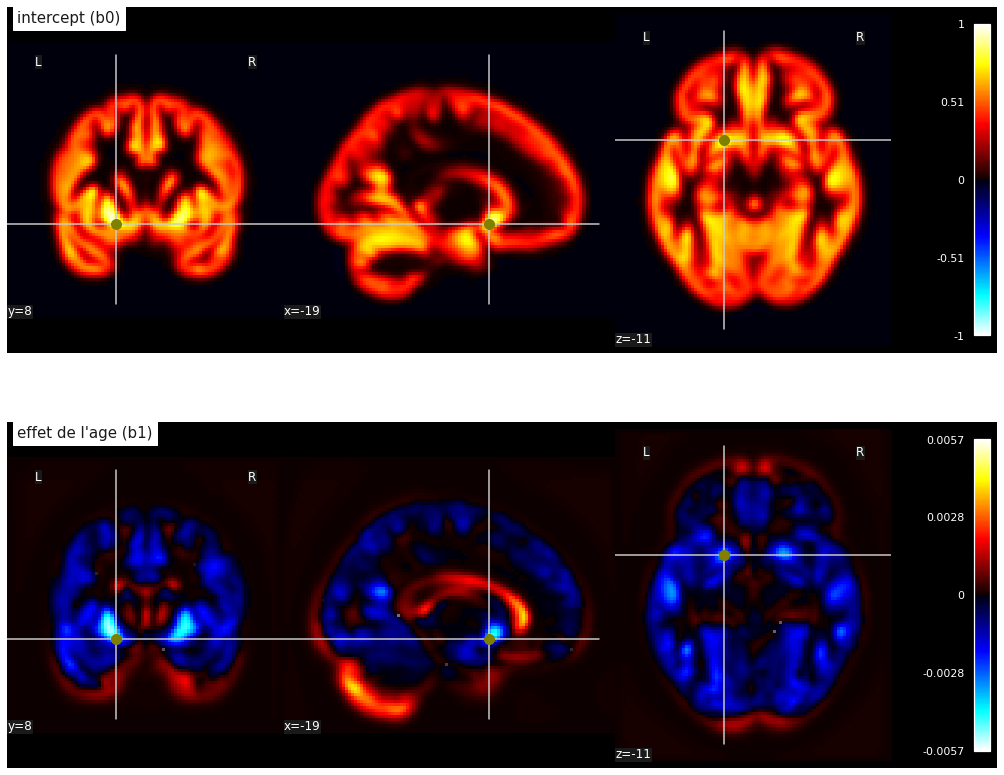

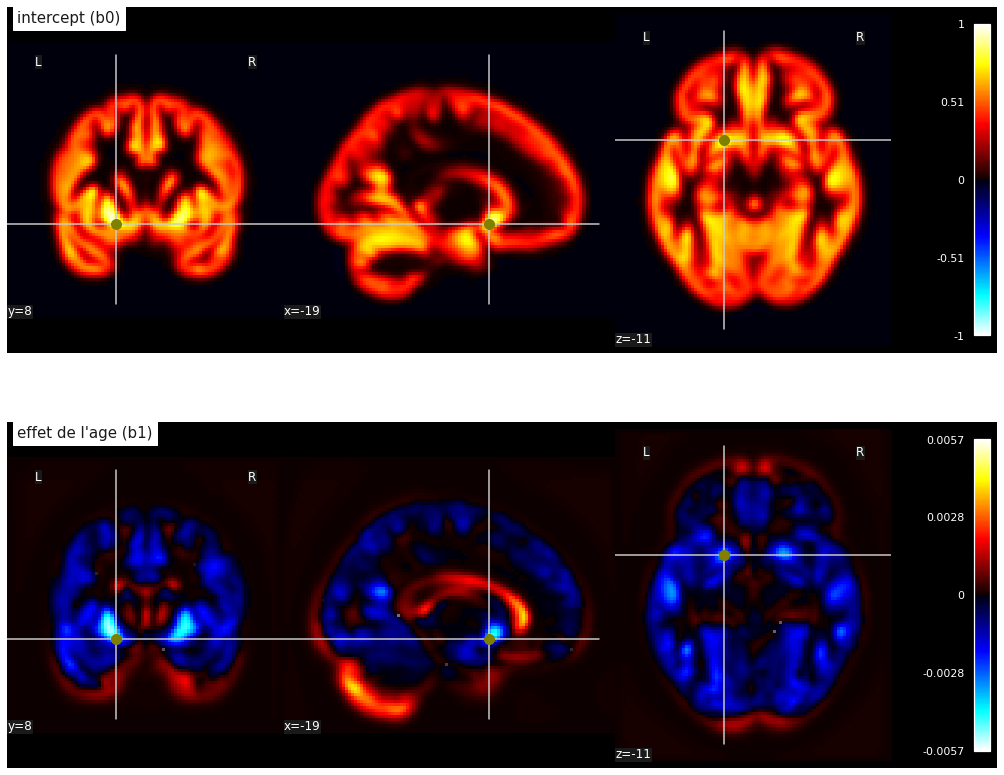

In [3]:
from nilearn.glm.second_level import make_second_level_design_matrix
design_df = df[["subject_label", "age"]].replace(['femelle', 'male'], value=[0, 1])
design_matrix = make_second_level_design_matrix(
    subject_label,
    design_df
    )
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=5.0)
second_level_model = second_level_model.fit(gray_matter_map_filenames,
                                            design_matrix=design_matrix)
beta0 = second_level_model.compute_contrast(second_level_contrast="intercept", output_type="effect_size")
beta1 = second_level_model.compute_contrast(second_level_contrast="age", output_type="effect_size")

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 14))

ax = plt.subplot2grid((2, 4), (0, 0), colspan=3)
roi_img = plotting.plot_stat_map(
    beta0, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='intercept (b0)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((2, 4), (1, 0), colspan=3)
roi_img = plotting.plot_stat_map(
    beta1, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='effet de l\'age (b1)')
roi_img.add_markers([coords[1]], colors[1], 100)

# On colle la figure dans le jupyter book
from myst_nb import glue
glue("b0-b1-fig", fig, display=False)           

```{glue:figure} b0-b1-fig
:figwidth: 600px
:name: b0-b1-fig
Cartes de paramètres statistiques dans une régression linéaire massivement univariée. Première ligne: intercept `b0`, deuxième ligne: effet linéaire de l'âge `b1`. Cette figure est adaptée d'un tutoriel de la librairie [nilearn](https://nilearn.github.io/auto_examples/05_glm_second_level/plot_oasis.html#sphx-glr-auto-examples-05-glm-second-level-plot-oasis-py) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```
Pour l'instant, nous avons utilisé un modèle de régression pour deux voxels seulement. Mais une carte VBM peut inclure des centaines de milliers de voxels. Les logiciels de neuroimagerie permettent d'effectuer systématiquement une régression linéaire pour l'ensemble des voxels, simultanément. Dans ce cas, on estime deux paramètres pour chaque voxel: `b0` (l'intercept) et `b1` (l'effet de l'âge). On va donc générer deux cartes statistiques séparées (voir {numref}`b0-b1-fig`). Ces deux cartes récapitulent donc des milliers de modèles de régression différents. Comme les régressions effectuées à chaque voxel sont indépendantes les unes des autres, on parle de modèle univarié. L'autre option, le modèle multivarié, chercherait plutôt à combiner les valeurs obtenues à différents voxels. De plus, comme on fait un très grand nombre de régressions en même temps, on parle de régression **massivement univariée**.

```{admonition} Statistiques et multimodalité
:class: tip
:name: stats-multimodales
Le modèle de régression est appliqué à plusieurs modalités de neuroimagerie. Dans ce chapitre, il est question d'un exemple utilisant la VBM. Mais le même modèle fonctionne dès lors qu'on a une série de cartes pour différents sujets. Il pourrait par exemple être utilisé en [IRMf](https://nilearn.github.io/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py) ou bien en TEP. Le même type de modèle peut aussi s'appliquer à des mesures prises sur des récepteurs en imagerie optique ou des mesures moyennes sur un faisceau de fibres en IRMd. Le modèle de régression est partout!
```

## Modèle linéaire général

### Variables

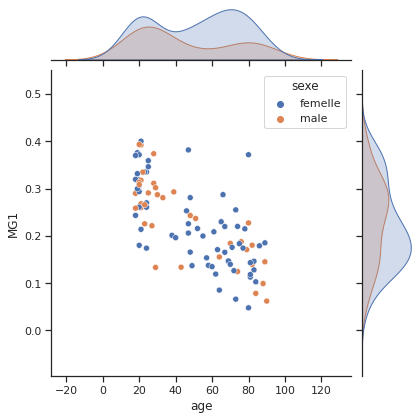

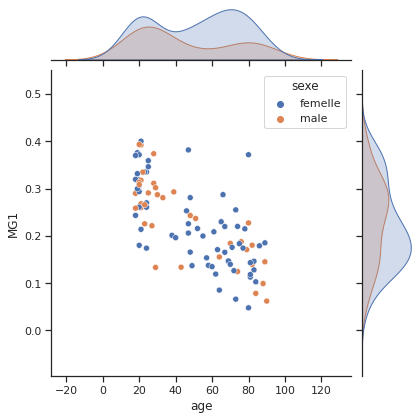

In [4]:
sns.set_theme(style="ticks")

# Show the joint distribution using kernel density estimation
fig = sns.jointplot(
    data=df,
    x="age", y="MG1", hue="sexe",
    kind="scatter",
)

# On colle la figure dans le jupyter book
from myst_nb import glue
glue("age-sexe-fig", fig.fig, display=False)           

```{glue:figure} age-sexe-fig
:figwidth: 600px
:name: age-sexe-fig
Relation entre âge, sexe et densité de matière grise pour un voxel (le voxel de couleur bleu dans {numref}`vbm-distribution-fig`). Le graphique est réalisé à l'aide de la libraire [seaborn](https://seaborn.pydata.org) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```

L'approche de régression linéaire que l'on vient de voir est simple et puissante, mais elle est limitée à deux variables. En neurosciences humaines, on ne se trouvera généralement pas dans ce cas. On va très souvent vouloir étudier des facteurs multiples de manière conjointe. Même si la représentation du sexe des participants par une variable binaire est [très (très) simplificatrice](https://blogs.scientificamerican.com/sa-visual/visualizing-sex-as-a-spectrum/) - sans compter la diversité de l'identité de genre - nous allons quand même essayer d'intégrer le sexe (mâle vs femelle) dans notre analyse. La figure ci-dessus montre les distributions d'âge et de matière grise (pour le voxel bleu), séparées par sexe. Ce graphique suggère que la distribution de matière grise est peut-être différente entre male et femelle, mais cette différence pourrait également être liée à l'âge. Le modèle linéaire général nous permet d'intégrer toutes ces variables dans une seule analyse.


### Régression multiple

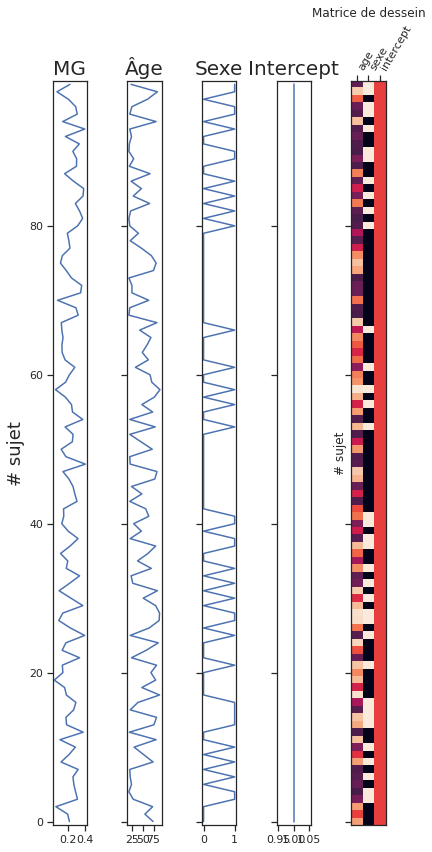

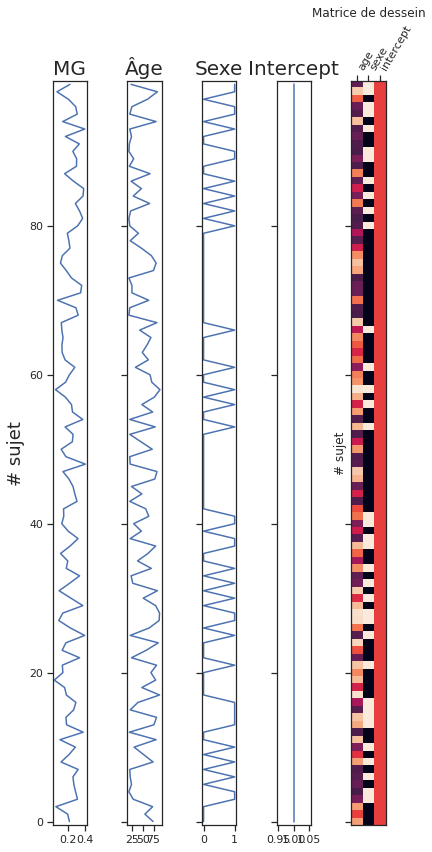

In [5]:
from nilearn.plotting import plot_design_matrix
design_df = df[["subject_label", "age", "sexe"]].replace(['femelle', 'male'], value=[0, 1])
design_matrix = make_second_level_design_matrix(
    subject_label,
    design_df
    )
fig, ax = plt.subplots(ncols=5, figsize=(6, 12), sharey=True)
Y = df["MG1"].to_numpy()
X = design_matrix.to_numpy()
ax[0].plot(np.expand_dims(Y, axis=1), range(len(Y)))
ax[1].plot(X[:,0], range(len(Y)))
ax[2].plot(X[:,1], range(len(Y)))
ax[3].plot(X[:,2], range(len(Y)))
ax[0].set_ylabel('# sujet', fontsize=18)
ax[0].set_title('MG', fontsize=20)
ax[1].set_title('Âge', fontsize=20)
ax[2].set_title('Sexe', fontsize=20)
ax[3].set_title('Intercept', fontsize=20)
plot_design_matrix(design_matrix, ax=ax[4])
ax[4].set_title('Matrice de dessein', fontsize=12)
ax[4].set_ylabel('# sujet')
plt.gca().invert_yaxis()
plt.tight_layout()

# On colle la figure dans le jupyter book
from myst_nb import glue
glue("design-matrix-fig", fig, display=False)           

```{glue:figure} design-matrix-fig
:figwidth: 600px
:name: design-matrix-fig
Variables pour une régression multiple. La variable dépendante est la densité de matière grise pour un voxel (MG, le voxel de couleur bleu dans {numref}`vbm-distribution-fig`). Les autres colonnes représentent les variations de l'âge, du sexe et de l'intercept à travers les sujets (variables prédictives). Les variables prédictives sont généralement représentées de manière plus compacte, sous la forme d'une image où la couleur de chaque pixel représente l'intensité du régresseur. Le graphique est adapté d'un [code python](https://dartbrains.org/content/GLM.html) produit par l'équipe Dartbrains, ainsi que d'un [tutoriel nilearn](https://nilearn.github.io/glm/first_level_model.html) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```

D'un point de vue mathématique, le modèle de régression multiple, parfois appelé modèle linéaire général, consiste simplement à incorporer plus de variables dans la "loi" qui tente de prédir la variable dépendante à partir des régresseurs:
`densite_matiere_grise = b0 + b1 * age + b2 * sexe + e`

Le seul nouveau coefficient est `b2`, qui dans ce cas mesure la différence entre la moyenne de matière grise entre les femelles (codées avec un 0 dans le modèle) et les mâles (codés avec un 1 dans le modèle), **après un ajustement pour l'âge des sujets**. Ce type de codage est utilisé avec les données catégorielles et est appelé "dummy variable" en anglais. Il permet d'intégrer des tests de différence de moyenne entre les groupes dans un modèle de régression.

```{admonition} Régression multiple et statistiques classiques
:class: tip
:name: stats-regression
Le modèle de régression multiple est très flexible. Il est possible de formuler la plupart des tests statistiques classiques tels que l'analyse de variance (ANOVA) ou bien le test d'égalité des moyennes de Student (t-test) à l'aide du modèle de régression linéaire. Voir ce [guide](https://lindeloev.github.io/tests-as-linear/) pour plus de détails.
```

### Cartes statistiques

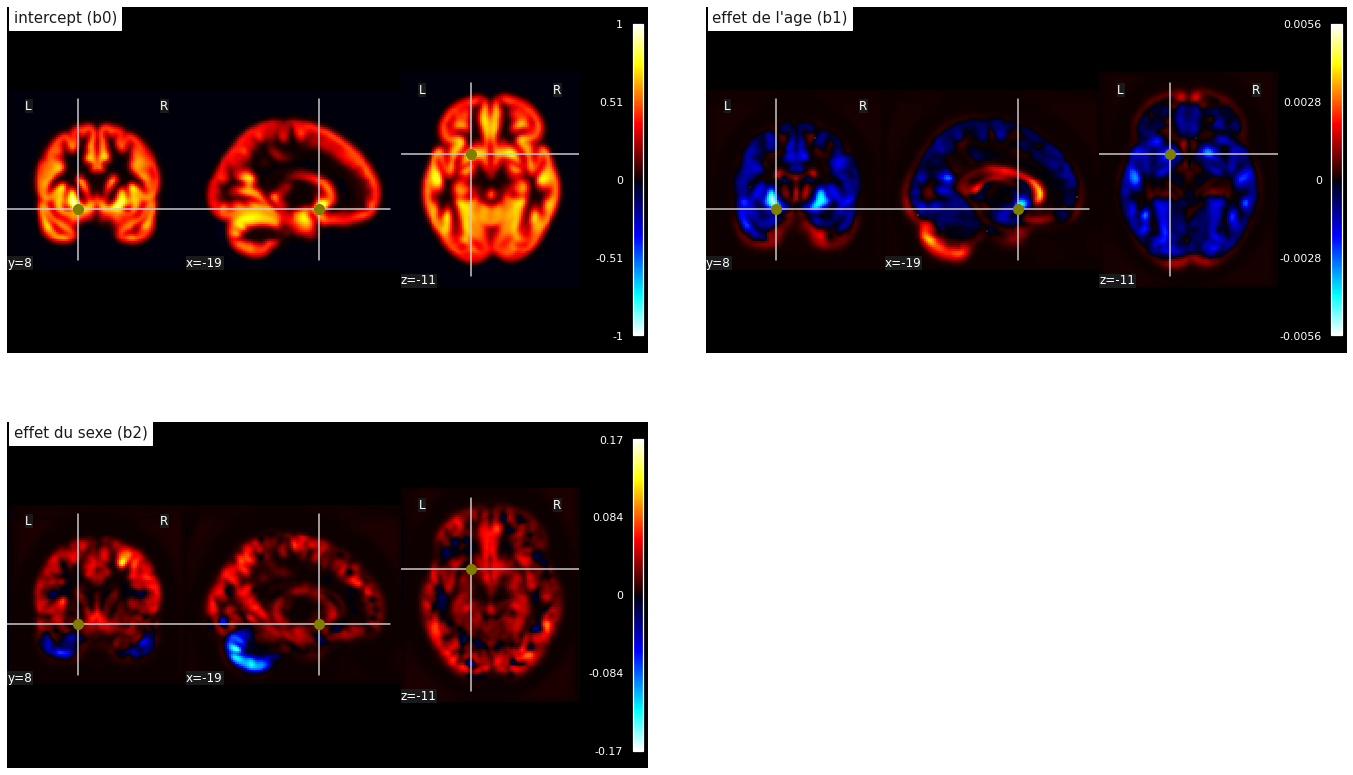

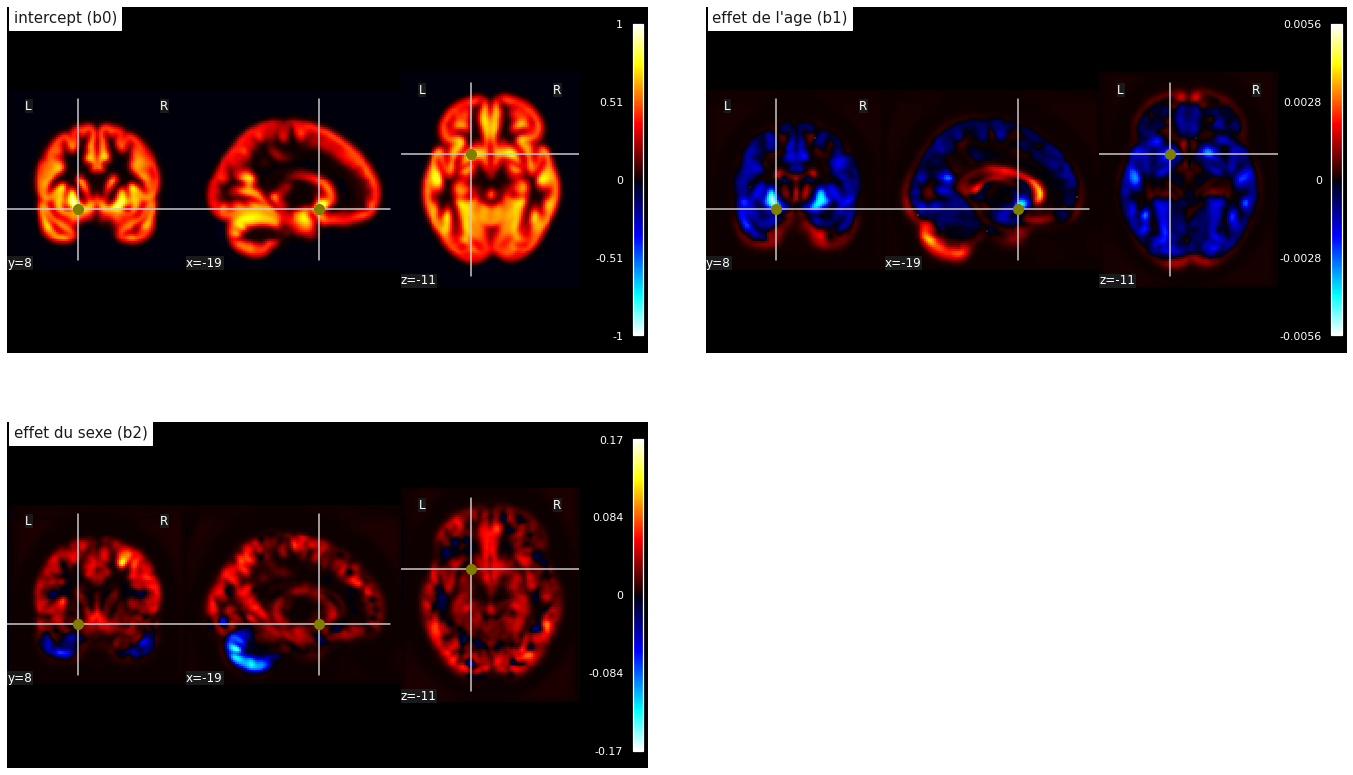

In [6]:
second_level_model = SecondLevelModel(smoothing_fwhm=5.0)
second_level_model = second_level_model.fit(gray_matter_map_filenames,
                                            design_matrix=design_matrix)
beta0 = second_level_model.compute_contrast(second_level_contrast="intercept", output_type="effect_size")
beta1 = second_level_model.compute_contrast(second_level_contrast="age", output_type="effect_size")
beta2 = second_level_model.compute_contrast(second_level_contrast="sexe", output_type="effect_size")

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 14))

ax = plt.subplot2grid((2, 4), (0, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    beta0, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='intercept (b0)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((2, 4), (0, 2), colspan=2)
roi_img = plotting.plot_stat_map(
    beta1, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='effet de l\'age (b1)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((2, 4), (1, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    beta2, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='effet du sexe (b2)')
roi_img.add_markers([coords[1]], colors[1], 100)

# On colle la figure dans le jupyter book
from myst_nb import glue
glue("multi-regression-fig", fig, display=False)           

```{glue:figure} multi-regression-fig
:figwidth: 800px
:name: multi-regression-fig
Cartes de paramètres statistiques dans une régression linéaire multiple massivement univariée. Haut gauche: intercept `b0`, haut droite: effet linéaire de l'âge `b1`, bas gauche: effet linéaire du sexe `b2`. Cette figure est adaptée d'un tutoriel de la librairie [nilearn](https://nilearn.github.io/auto_examples/05_glm_second_level/plot_oasis.html#sphx-glr-auto-examples-05-glm-second-level-plot-oasis-py) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```

Une caractéristique qui peut être légèrement contre-intuitive avec la régression multiple est que la carte présentant l'effet de l'âge ici est différente de celle présentée dans la section portant sur la régression simple. En effet, l'effet de l'âge est maintenant évalué _après avoir pris en compte des différences de sexe_. Malgré cela, le résultat de la régression n'a pas changé de manière frappante: le cortex s'atrophie avec l'âge (en bleu), alors que le liquide céphalo-rachidien s'étend (en rouge). Ce qui apparait comme une expansion de la matière grise reflète probablement des effets de volume partiel et des tissus classifiés incorrectement comme de la matière grise. L'analyse sur la variable `sexe` montre que la densité de matière grise est plus élevée (en moyenne) dans le cortex chez les hommes, alors que la tendance est inversée au niveau du cervelet.

## Tests statistiques

### Tests t et valeur p

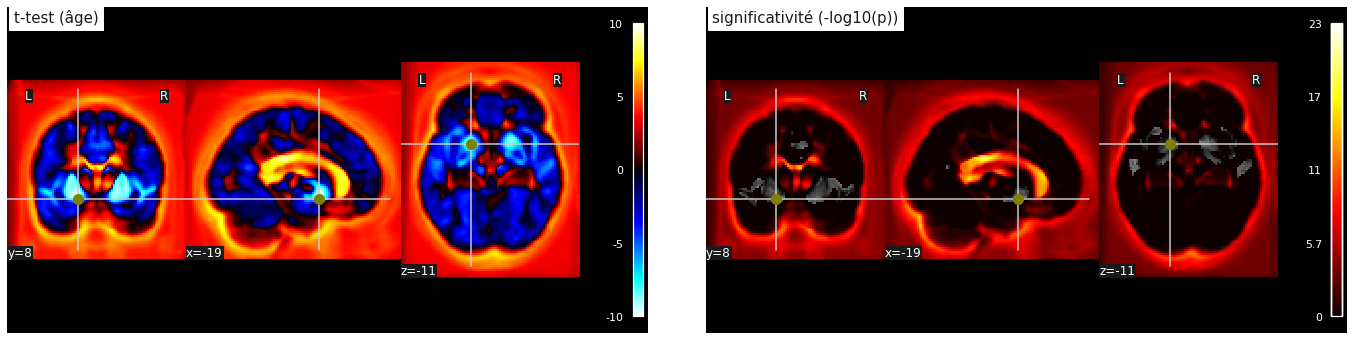

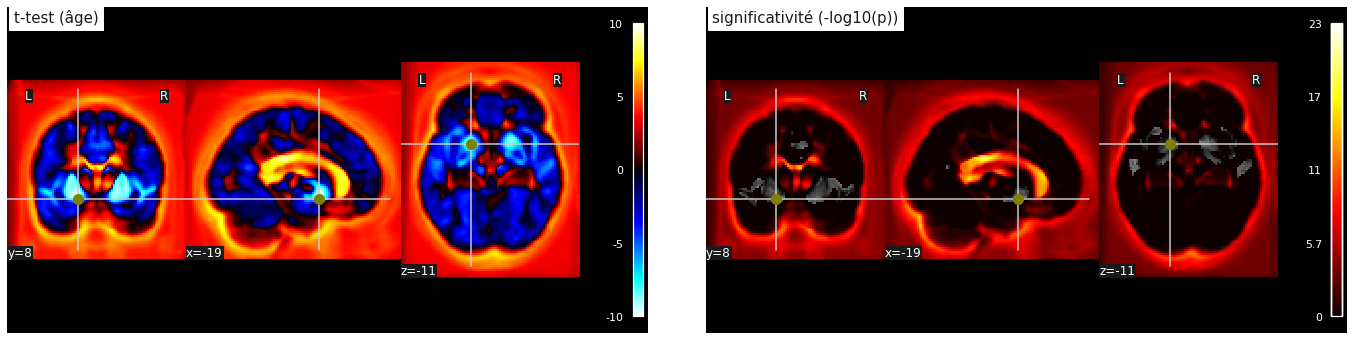

In [7]:
from nilearn.image import math_img
z_score = second_level_model.compute_contrast(second_level_contrast="age", output_type="z_score")
p_value = second_level_model.compute_contrast(second_level_contrast="age", output_type="p_value")
neg_log_pval = math_img("-np.log10(np.minimum(1, img))", img=p_value)

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 6))

ax = plt.subplot2grid((1, 4), (0, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test (âge)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((1, 4), (0, 2), colspan=2)
roi_img = plotting.plot_stat_map(
    neg_log_pval, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='significativité (-log10(p))')
roi_img.add_markers([coords[1]], colors[1], 100)

# On colle la figure dans le jupyter book
from myst_nb import glue
glue("tmap-pval-fig", fig, display=False)           

```{glue:figure} tmap-pval-fig
:figwidth: 800px
:name: tmap-pval-fig
 Tests statistiques sur la significativité de l'association entre densité de matière grise et âge. Test t de Student (haut) et log10(p) (bas). Cette figure est adaptée d'un tutoriel de la librairie [nilearn](https://nilearn.github.io/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```
Une fois que l'on a estimé l'effet de certaines variables explicatives (par exemple, l'âge) sur notre variable dépendante (par exemple, la densité de matière grise), il est nécessaire de tester la **significativité** de cet effet. À cette fin, on utilise l'amplitude des résidus pour estimer la taille d'effet que l'on pourrait observer par chance, si uniquement ces résidus étaient présents. On en déduit un test `t` de Student, qui se comporte comme une [loi normale](https://fr.wikipedia.org/wiki/Loi_normale) quand le nombre de sujets est grand. Pour chaque voxel, on a donc une statistique `t` différente, et on peut calculer la probabilité `p` d'observer cette statistique sous l'**hypothèse nulle**, où l'effet de la variable explicative est exactement zéro.

### Hypothèse nulle

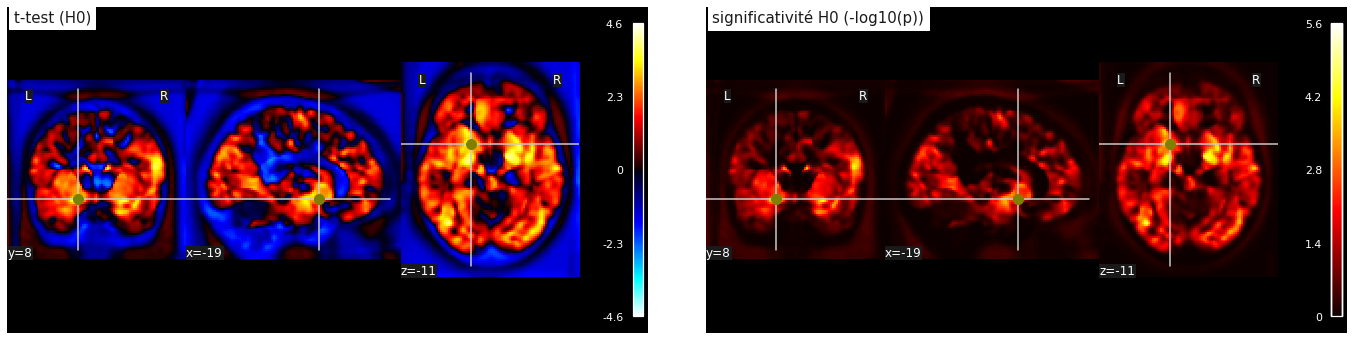

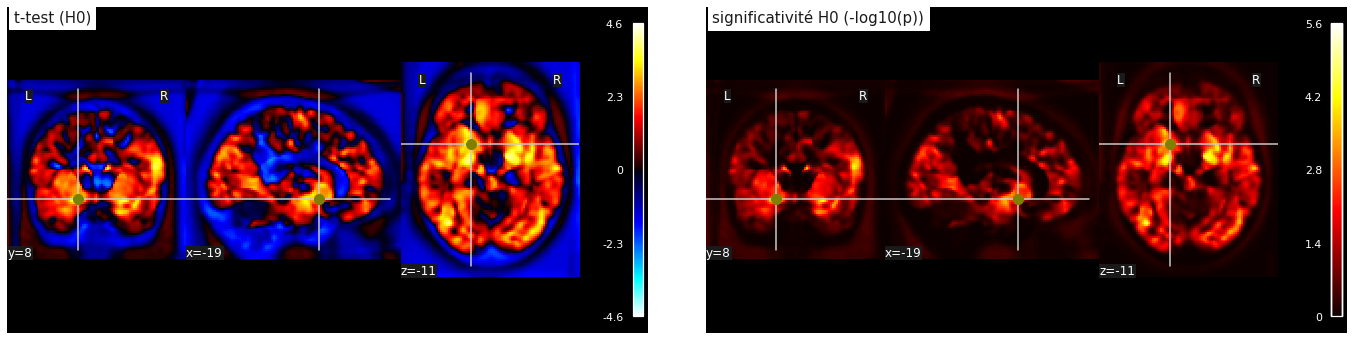

In [8]:
from numpy.random import seed
from numpy.random import shuffle
# seed random number generator
seed(1)
design_rand_df = df[["subject_label", "age"]].replace(['femelle', 'male'], value=[0, 1])
design_rand_matrix = make_second_level_design_matrix(
    subject_label,
    design_df
    )
shuffle(design_rand_matrix["age"].to_numpy())

second_level_model_rand = SecondLevelModel(smoothing_fwhm=5.0)
second_level_model_rand = second_level_model.fit(gray_matter_map_filenames,
                                            design_matrix=design_rand_matrix)

z_score_rand = second_level_model_rand.compute_contrast(second_level_contrast="age", output_type="z_score")
p_value_rand = second_level_model_rand.compute_contrast(second_level_contrast="age", output_type="p_value")
neg_log_pval_rand = math_img("-np.log10(np.minimum(1, img))", img=p_value_rand)

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 6))

ax = plt.subplot2grid((1, 4), (0, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score_rand, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test (H0)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((1, 4), (0, 2), colspan=2)
roi_img = plotting.plot_stat_map(
    neg_log_pval_rand, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='significativité H0 (-log10(p))')
roi_img.add_markers([coords[1]], colors[1], 100)

# On colle la figure dans le jupyter book
from myst_nb import glue
glue("null-fig", fig, display=False)           

```{glue:figure} null-fig
:figwidth: 800px
:name: null-fig
 Tests statistiques sur la significativité de l'association entre densité de matière grise et âge, sous l'hypothèse nulle où il n'existe aucune association. Les données d'âge ont été permutées aléatoirement entre les sujets. Test t de Student (haut) et log10(p) (bas). Cette figure est adaptée d'un tutoriel de la librairie [nilearn](https://nilearn.github.io/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```
Au coeur de l'interprétation de la valeur `p`, il y a ce qu'on appelle l'**hypothèse nulle**. Pour essayer de comprendre ce que cela veut dire, faisons une expérience. Nous allons recommencer toute la procédure d'estimation de l'effet de l'âge sur la densité de matière grise. Mais cette fois ci, au lieu d'utiliser l'âge réel des sujets, nous allons mélanger ces valeurs aléatoirement (on parle de [permutations](https://fr.wikipedia.org/wiki/Permutation)). La distribution des tests `t` et des valeurs `p` est présentée dans la {numref}`null-fig`. De manière frappante, les valeurs `t` sont beaucoup plus petites avec les valeurs d'âge aléatoires que lorsqu'on a fait l'analyse avec les vraies valeurs, mais certaines valeurs restent élevées. On a réalisé une expérience sous l'hypothèse nulle, où il n'existe aucune association avec l'âge. La valeur `p` nous indique la **fréquence** avec laquelle on trouvera des valeurs d'effet de l'âge plus élevées sous l'hypothèse nulle que dans l'échantillon original. Pour estimer cela directement, il faudrait recommencer l'expérience que l'on vient de faire avec des milliers de permutations! Mais il existe aussi des méthodes approximées plus rapide.

### Comparaisons multiples

/home/pbellec/env/psy3018/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


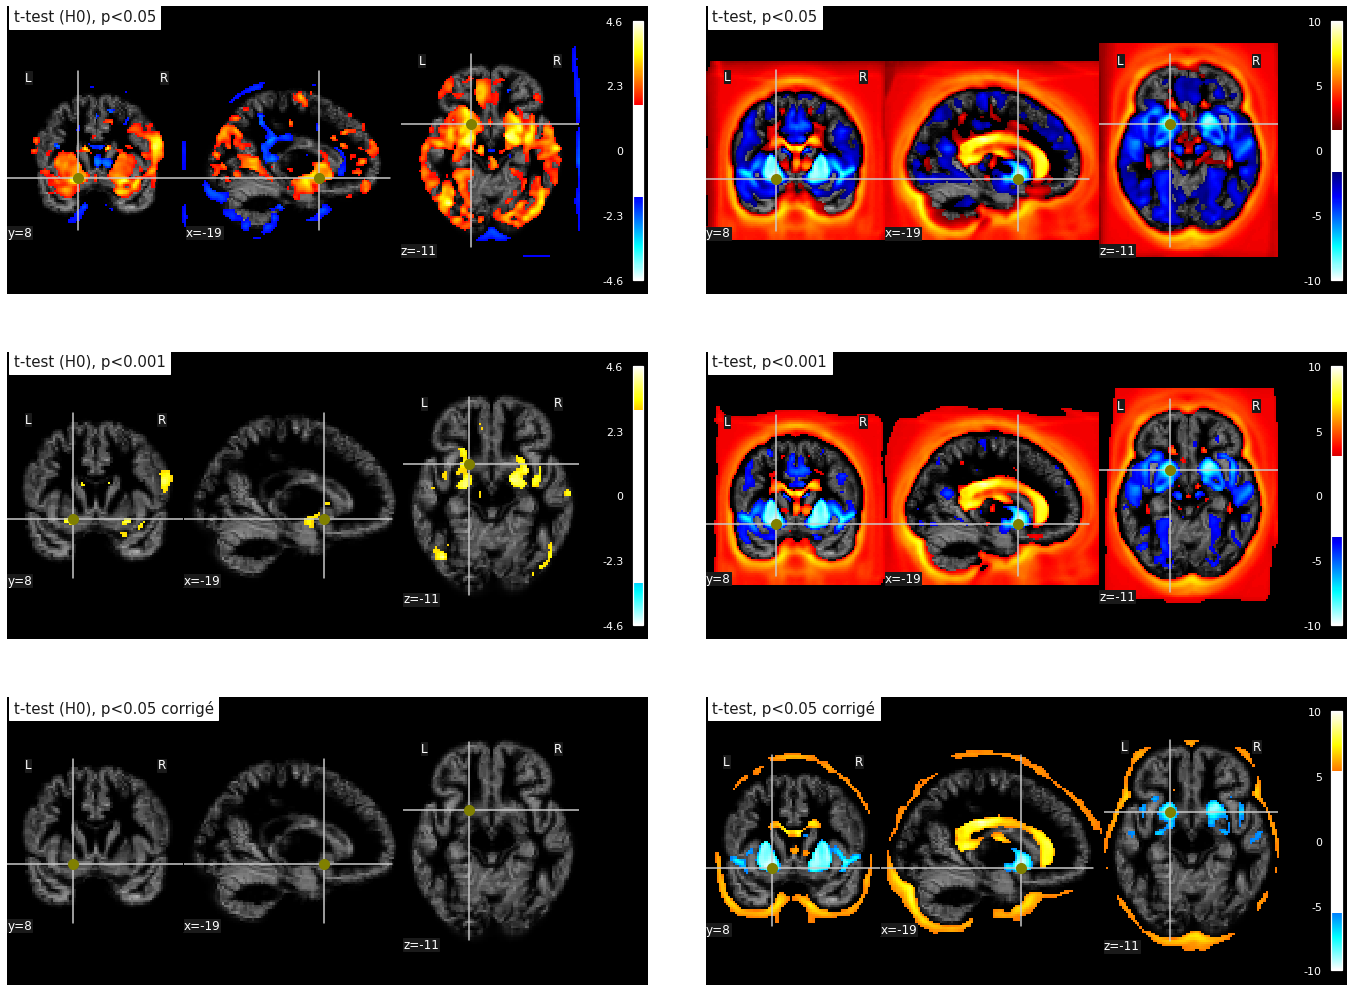

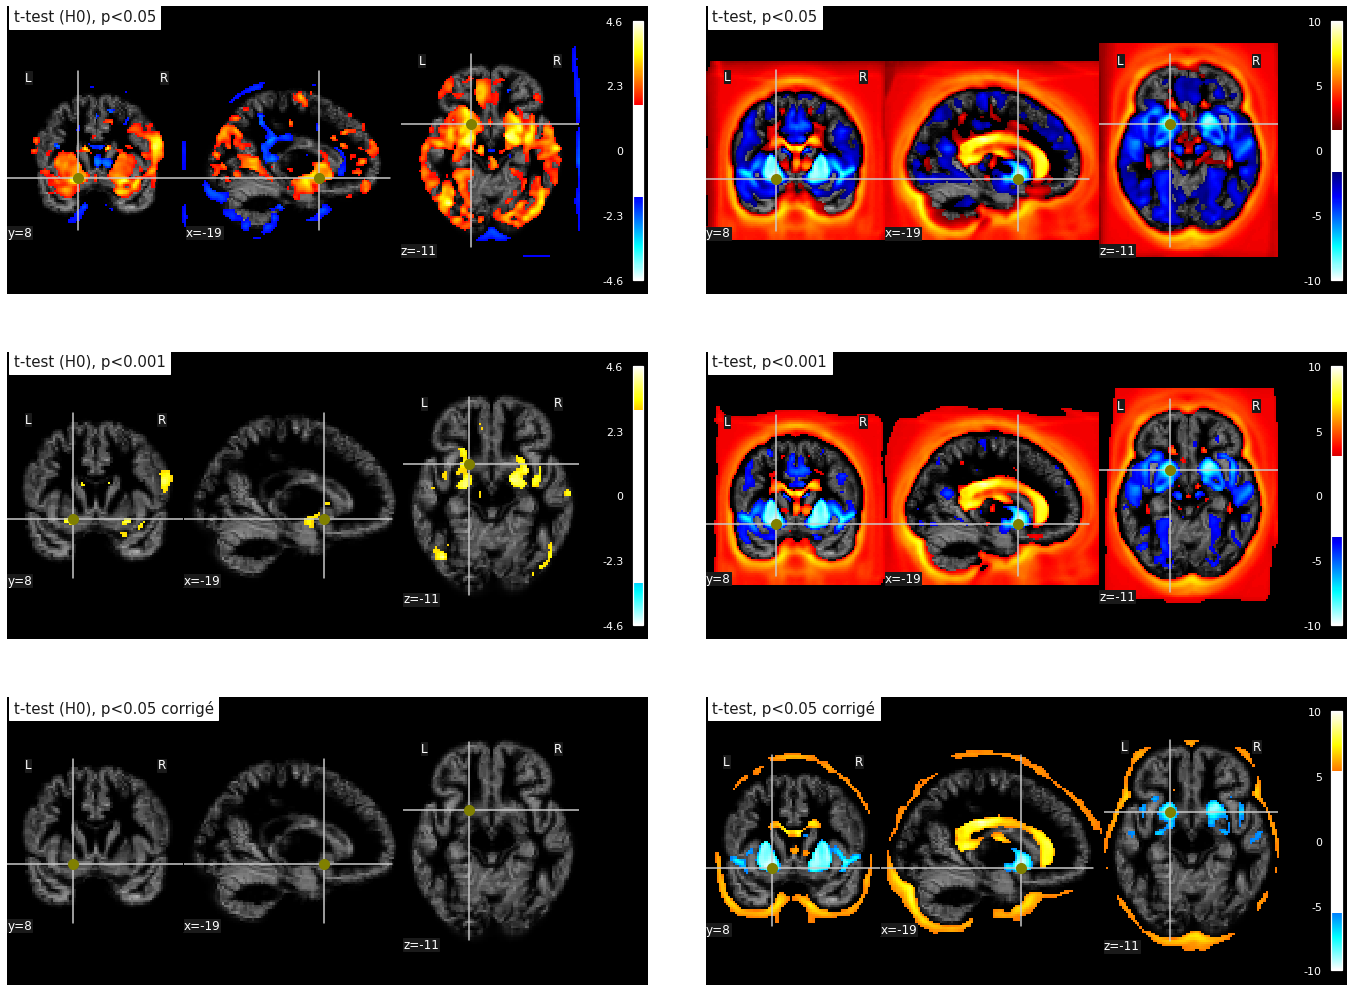

In [9]:
from nilearn.glm import threshold_stats_img
from scipy.stats import norm
p_val = 0.001
p001_uncorrected = norm.isf(p_val)
p_val = 0.05
p05_uncorrected = norm.isf(p_val)

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 18))

ax = plt.subplot2grid((3, 4), (0, 2), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score, threshold=p05_uncorrected, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test, p<0.05')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((3, 4), (1, 2), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score, threshold=p001_uncorrected, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test, p<0.001')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((3, 4), (2, 2), colspan=2)
thresholded_map, threshold = threshold_stats_img(
    z_score, alpha=.05, height_control='bonferroni')
roi_img = plotting.plot_stat_map(
    z_score, threshold=threshold, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test, p<0.05 corrigé')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((3, 4), (0, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score_rand, threshold=p05_uncorrected, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test (H0), p<0.05')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((3, 4), (1, 0), colspan=2)
roi_img = plotting.plot_stat_map(
    z_score_rand, threshold=p001_uncorrected, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test (H0), p<0.001')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((3, 4), (2, 0), colspan=2)
thresholded_map_rand, threshold_rand = threshold_stats_img(
    z_score_rand, alpha=.05, height_control='bonferroni')
roi_img = plotting.plot_stat_map(
    z_score_rand, threshold=threshold_rand, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='t-test (H0), p<0.05 corrigé')
roi_img.add_markers([coords[1]], colors[1], 100)

# On colle la figure dans le jupyter book
from myst_nb import glue
glue("threshold-fig", fig, display=False)           

```{glue:figure} threshold-fig
:figwidth: 800px
:name: threshold-fig
 Effet de différentes stratégies de seuillage sur l'association entre l'âge et la densité de matière grise. À gauche: données sous l'hypothèse nulle (valeurs d'âge permutée au travers des sujets). À droite: données originales. Ligne 1: seuil `p<0.05` non corrigé pour les comparaisons multiples; ligne 2: seuil `p<0.001` non corrigé pour les comparaisons multiples; seuil `p<0.05` corrigé pour les comparaisons multiples par l'approche de Bonferroni. Cette figure est adaptée d'un tutoriel de la librairie [nilearn](https://nilearn.github.io/auto_examples/05_glm_second_level/plot_thresholding.html#sphx-glr-auto-examples-05-glm-second-level-plot-thresholding-py) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```

Maintenant que l'on a discuté de l'interprétation de la valeur `p`, on doit maintenant décider d'un seuil à appliquer sur les valeurs `p`. Si l'on utilise le seuil habituel `p<0.05`, cela signifie que pour 20 permutations, on détectera une association 1 fois (en moyenne) pour un voxel donné. Mais comme on a des milliers de voxels dans le cerveau, cela veut dire que l'on va détecter 5% du cerveau (en moyenne) pour chaque permutation! C'est ce que l'on observe (et même plus) dans la figure en haut à gauche {numref}`threshold-fig`. Il s'agit du **problème de comparaisons multiples**, et plus on fait de tests, plus ce problème est important.

Si l'on abaisse le seuil à `p<0.001`, on ne détecte plus que 0.1% du cerveau (en moyenne) sous l'hypothèse nulle, et on observe en effet une réduction du nombre de voxels dans la figure de gauche, 2ième ligne {numref}`threshold-fig`.

La méthode la plus simple pour corriger du problème de comparaisons multiples est d'utiliser un seuil corrigé `p<0.05/N`, où N est le nombre de comparaisons (c'est à dire de tests). Dans notre cas, on a approximativement 100,000 voxels, donc on va utiliser `p<0.0000001`! Avec cette stratégie, aucun voxel ne passe le seuil dans notre expérience sous l'hypothèse nulle, voir figure en bas à gauche {numref}`threshold-fig`. En général c'est ce qui se passera (en moyenne) pour 19/20 permutations.

Si l'on observe maintenant l'effet de ces différentes stratégies sur les données originales, on observe que plus le seuil `p` est petit, moins on détecte d'effets significatifs. Malgré tout, même avec `p<0.05` corrigé par l'approche de Bonferroni, on détecte toujours les effets principaux de l'âge.

```{admonition} Compromis résolution / puissance
:class: tip
:name: resolution-power
En règle général, on doit faire un compromis entre la résolution (notre capacité à détecter des effets dans de petites régions du cerveau) et la puissance statistique (notre capacité à détecter des effets de petite taille). Si l'on veut une excellente résolution, on fait des tests à tous les voxels, mais on doit corriger pour un très grand nombre de comparaisons multiples. En revanche, si l'on ne teste qu'une valeur moyenne sur une région, on n'a qu'un seul test et aucune correction à appliquer, mais on ne sait pas ce qui se passe dans le reste du cerveau, ou à l'intérieur de cette région.
```
## Conclusion

* Le modèle de régression simple permet de prédire les observations d'une variable dépendante à partir d'une varible explicative.
* Ce modèle est appliqué indépendamment à chaque voxel (approche massivement multivariée).
* Il est possible d'utiliser le modèle linéaire général pour tester simultanément l'effet de plusieurs variables explicatives sur la variable dépendante.
* Quand on effectue un grand nombre de tests statistiques à chaque voxel, il faut modifier le seuil de significativité du test (problème de comparaisons multiples).

## Exercices

```{admonition} Exercice 9.1
:class: note
On souhaite comparer la connectivité entre deux groupes de sujets, jeunes vs âgés.
Décrivez les variables prédictives à inclure dans un modèle de régression.  
Quelles autres variables vous semblent-elles importantes à inclure dans le modèle?
```

```{admonition} Exercice 9.2
:class: note
Vrai/faux (expliquez pourquoi)
Le modèle de régression peut être utilisé pour effectuer des statistiques de groupe pour les types de mesures suivantes… (vrai/faux)
 * IRMf
 * IRM T1 (VBM)
 * IRM T1 (volumétrie)
 * IRM T1 (épaisseur corticale)
 * Données comportementales
 * Tomographie par émission de positrons
 * Imagerie optique
 * Imagerie de diffusion
```

```{admonition} Exercice 9.3
:class: note
Vrai/faux. On observe une différence de moyenne entre deux groupes, et l’on effectue un test statistique qui nous donne une valeur p.
 * La valeur p est la probabilité qu’il n’y ait pas de vraie différence.
 * Une faible valeur p indique une forte probabilité qu’il y ait une vraie différence.
 * La valeur p indique la probabilité d’observer cette différence, au moins, s’il n’existait vraiment aucune différence entre les deux groupes.
```

```{admonition} Exercice 9.4
:class: note
Vrai/faux. Un problème de comparaisons multiples signifie.
 * Qu’on effectue de manière répétée des test statistiques générant une valeur p.
 * Que l’on répète un test statistique à chaque voxel dans une image du cerveau, par exemple.
 * Que l’on teste beaucoup d’hypothèses dans un article, par exemple.
 * Que l’on a quatre sous-groupes, et que l’on compare chacune des trois paires possibles de sous-groupes, par exemple.
```

```{admonition} Exercice 9.5
:class: note
Classer les analyses suivantes du plus petit au plus grand, en fonction du nombre de comparaisons multiples impliquées. Indiquez le nombre approximatif de comparaisons.
On compare la densité de matière grise entre deux groupes de sujets à chaque voxel du cerveau.
On compare le métabolisme du glucose entre deux groupes de sujets à chaque voxel du cerveau, à l’aide du FDG-TEP.
On compare le volume de régions cérébrales entre deux groupes de sujets, à partir d’un atlas qui comprend 90 régions.
On compare le volume de l’hippocampe entre deux groupes de sujets.
```

```{admonition} Exercice 9.6
:class: note
Pour répondre aux questions de cet exercice, lisez d'abord l'article *Tau pathology in cognitively normal older adults* de Ziontz et collaborateurs (disponible comme [preprint](https://doi.org/10.1101/611186 ) sur Biorxiv sous licence CC0 et publié dans le journal Alzheimer's & Dementia: Diagnosis, Assessment & Disease Monitoring [doi](https://doi.org/10.1016/j.dadm.2019.07.007). Les questions suivantes requièrent des réponses à développement court.
Pour répondre aux questions de cet exercice, on s'intéresse à la section 2.5.1 de l'article *Tau pathology in cognitively normal older adults* de Ziontz et collaborateurs (disponible comme [preprint](https://doi.org/10.1101/611186 ) sur Biorxiv sous licence CC0 et publié dans le journal Alzheimer's & Dementia: Diagnosis, Assessment & Disease Monitoring [doi](https://doi.org/10.1016/j.dadm.2019.07.007). Les questions suivantes requièrent des réponses à développement court.
- Quelle est la variable dépendante du modèle linéaire?
- Quelles variables explicatives sont incluses dans le modèle linéaire?
- Sait on combien de comparaisons multiples sont faites?
- Comment est ce que les comparaisons multiples sont corrigées?
```